Trying to code up a CNN based on resnet50 from scratch.

In [7]:
from importlib import reload
import flymovie as fm
import cnn_models.siamese_cnn as cn
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pickle
import tensorflow as tf
from pathlib import Path

from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet



In [8]:
cache_dir = Path('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims-test_FFr6jKb9jy')
target_shape = (100, 100)
channels_axis=1

def preprocess_image_fromfile(filename):
    with open(filename, 'rb') as file:
        image = pickle.load(file)
    return preprocess_image(image)

def preprocess_image(image):
    """
    Load the specified pkl file, make max intensity projection, normalize.
    """
    mip = image.max(axis=0)
    mip = mip.astype('float32')
    mip = np.expand_dims(mip, axis=0)
    #mip = np.vstack([mip, mip, mip])
    #mip = np.swapaxes(mip, 0, 2)
    # Normalize 0-1.
    mip = (mip - np.min(mip)) / np.max(mip) 
    return mip

cache_dir = Path(cache_dir)
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

# Create lists of sorted files for anchor and positive images.
anchor_image_files = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_image_files = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_image_files)

# To generate the list of negative images, randomize the list of
# available images and concatenate them together.
negative_image_files = anchor_image_files + positive_image_files
np.random.RandomState(seed=32).shuffle(negative_image_files)
np.random.RandomState(seed=16).shuffle(negative_image_files)
np.random.RandomState(seed=8).shuffle(negative_image_files)

# Apply preprocessing to all input images, return as lists.
anchor_images = list(map(preprocess_image_fromfile, anchor_image_files))
positive_images = list(map(preprocess_image_fromfile, positive_image_files))
negative_images = list(map(preprocess_image_fromfile, negative_image_files))

In [9]:
# Convert lists to tf datasets, shuffle the negatives again for good measure.
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

In [6]:
cn.make_triplet_inputs(cache_dir)

(<PrefetchDataset shapes: ((None, 1, 100, 100), (None, 1, 100, 100), (None, 1, 100, 100)), types: (tf.float32, tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 1, 100, 100), (None, 1, 100, 100), (None, 1, 100, 100)), types: (tf.float32, tf.float32, tf.float32)>)

In [10]:
train_dataset, val_dataset = cn.make_triplet_inputs(cache_dir)

In [13]:
base_cnn = cn.make_base_cnn(image_shape=(100,100))
embedding = cn.make_embedding(base_cnn)
siamese_network = cn.make_siamese_network(embedding)
siamese_model = cn.SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
history = siamese_model.fit(train_dataset, epochs=2, validation_data=val_dataset, verbose=True)


Epoch 1/2


2021-12-16 10:43:29.483429: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


3/3 [==============================] - 10s 2s/step - loss: 1.2439 - val_loss: 1.8170
Epoch 2/2
3/3 [==============================] - 3s 986ms/step - loss: 0.6969 - val_loss: 0.8368


In [ ]:
model = tf.keras.models.load_model('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/model')

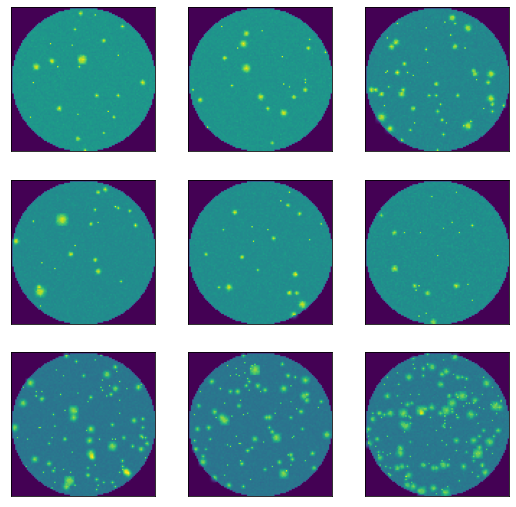

In [15]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i][0])
        show(axs[i, 1], positive[i][0])
        show(axs[i, 2], negative[i][0])

visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [16]:
sample = next(iter(train_dataset))
#visualize(*sample)

anchor, positive, negative = sample
anchor = anchor.numpy()
positive = positive.numpy()
negative = negative.numpy()
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(preprocess_image(anchor)),
    embedding(preprocess_image(positive)),
    embedding(preprocess_image(negative)),
)

cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


Positive similarity: 0.9868847
Negative similarity 0.98840463


In [17]:
embedding = tf.keras.models.load_model('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/model')

In [18]:
sample = next(iter(train_dataset))
#visualize(*sample)

anchor, positive, negative = sample
anchor = anchor.numpy()
positive = positive.numpy()
negative = negative.numpy()
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(preprocess_image(anchor)),
    embedding(preprocess_image(positive)),
    embedding(preprocess_image(negative)),
)

cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


Positive similarity: 0.9915954
Negative similarity 0.99017155


I think the thing to do is code this up for use on the big machine.

Scripts:

1. Define network, from base cnn on
2. Load network, preprocess data, fit model, eval.
3. Generate sims, auto shift to left and right buckets.

Two things to potentially add:

1. Learning rate scheduler (prob a good idea)
2. Try out curriculum?

In [19]:
class TestData():
    def __init__(self):
        pass